In [69]:
import pandas as pd
import networkx as nx 
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import itertools
import re
import spacy
import numpy as np

# Загрузка данных


In [2]:
df_raw = pd.read_csv(r"D:\hh_2006-2020\vacancies_2016.csv")

In [3]:
display(df_raw.head(3))
display(df_raw.shape)

,id,description,key_skills,schedule_id,schedule_name,accept_handicapped,accept_kids,experience_id,experience_name,specializations,...,address_lng,alternate_url,apply_alternate_url,code,department_id,department_name,employment_id,employment_name,prof_classes_found,terms_found
0,16260123,<p>Современная и амбициозная российская компан...,UML\nUse Case Analysis\nнаписание технических ...,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,"1.221 Программирование, Разработка 1 Информаци...",...,NaN,https://hh.ru/vacancy/16260123,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,analyst,техническое_образование конкурентная_зарплата ...
1,16260126,"<p><em><strong>Развивающаяся компания, успешно...",Активные продажи\nХолодные продажи\nВедение пе...,fullDay,Полный день,False,False,between3And6,От 3 до 6 лет,"1.225 Продажи 1 Информационные технологии, инт...",...,NaN,https://hh.ru/vacancy/16260126,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,support,кофе team коммуникативные_навыки crm мониторин...
2,16260127,<p><strong>Требования:</strong></p> <p>1.Продв...,NaN,flexible,Гибкий график,True,False,noExperience,Нет опыта,"1.172 Начальный уровень, Мало опыта 1 Информац...",...,NaN,https://hh.ru/vacancy/16260127,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,part,Частичная занятость,manager,гибкий_график желание_работать ms_excel официа...


(332460, 56)

# Фильтрация

In [4]:
df_mask_have_skills = df_raw["key_skills"].notna()
print(f"{df_mask_have_skills.sum()}/{df_mask_have_skills.shape[0]}  {df_mask_have_skills.sum()/df_mask_have_skills.shape[0] * 100:.3}%")

81745/332460  24.6%


In [5]:
df_have_skills = df_raw[df_mask_have_skills]

# Подготовка данных

### Подготовка столбца навыков

In [6]:
df_have_skills.loc[:,"key_skills_pars"] = df_have_skills["key_skills"].apply(lambda x: x.split("\n"))
df_have_skills

C:\Users\d5767\AppData\Local\Temp\ipykernel_17064\2668879597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_have_skills.loc[:,"key_skills_pars"] = df_have_skills["key_skills"].apply(lambda x: x.split("\n"))


,id,description,key_skills,schedule_id,schedule_name,accept_handicapped,accept_kids,experience_id,experience_name,specializations,...,alternate_url,apply_alternate_url,code,department_id,department_name,employment_id,employment_name,prof_classes_found,terms_found,key_skills_pars
0,16260123,<p>Современная и амбициозная российская компан...,UML\nUse Case Analysis\nнаписание технических ...,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,"1.221 Программирование, Разработка 1 Информаци...",...,https://hh.ru/vacancy/16260123,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,analyst,техническое_образование конкурентная_зарплата ...,"[UML, Use Case Analysis, написание технических..."
1,16260126,"<p><em><strong>Развивающаяся компания, успешно...",Активные продажи\nХолодные продажи\nВедение пе...,fullDay,Полный день,False,False,between3And6,От 3 до 6 лет,"1.225 Продажи 1 Информационные технологии, инт...",...,https://hh.ru/vacancy/16260126,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,support,кофе team коммуникативные_навыки crm мониторин...,"[Активные продажи, Холодные продажи, Ведение п..."
5,16260140,<p><em><strong>Федеральная компания с иностран...,Анализ БД\nРабота с базами данных\nMS Office\n...,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,1.117 Тестирование 1 Информационные технологии...,...,https://hh.ru/vacancy/16260140,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,analyst,статистика ms_excel ms_office аналитик опыт_ра...,"[Анализ БД, Работа с базами данных, MS Office,..."
7,16260148,<p>.NET Developer (Relocation to Czech Republi...,.NET Framework\nC#\nASP.NET\nMVC,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,"1.221 Программирование, Разработка 1 Информаци...",...,https://hh.ru/vacancy/16260148,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,programmer,javascript css wcf agile рефакторинг навыки_пр...,"[.NET Framework, C#, ASP.NET, MVC]"
16,16260323,<p><strong>Обязанности</strong>:</p> <ul> <li>...,Работа с интернет-агрегаторами\nКонтекстная ре...,fullDay,Полный день,True,False,between3And6,От 3 до 6 лет,"17.302 FMCG, Товары народного потребления 17 П...",...,https://hh.ru/vacancy/16260323,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,specialist,высшее_образование site kpi яндекс мониторинг ...,"[Работа с интернет-агрегаторами, Контекстная р..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332449,16029911,<p>Проект над которым мы работаем – создание о...,JavaScript\nNode.js\nGit,remote,Удаленная работа,True,False,between3And6,От 3 до 6 лет,"1.221 Программирование, Разработка 1 Информаци...",...,https://hh.ru/vacancy/16029911,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,programmer,webpack typescript css team django javascript ...,"[JavaScript, Node.js, Git]"
332451,16029929,<p>Вакансия Битрикс-разработчика идеальна для ...,1С-Битрикс\nBitrix\nFramework\nООП\nPHP\nPHP5\...,remote,Удаленная работа,False,False,between3And6,От 3 до 6 лет,"1.221 Программирование, Разработка 1 Информаци...",...,https://hh.ru/vacancy/16029929,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,project,Проектная работа,programmer,1c css soap xslt xhtml php архитектура английс...,"[1С-Битрикс, Bitrix, Framework, ООП, PHP, PHP5..."
332454,16029959,"<p>На постоянную работу, в хостинг компанию тр...",Unix\nFreeBSD\nАдминистрирование серверов Linu...,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,1.270 Сетевые технологии 1 Информационные техн...,...,https://hh.ru/vacancy/16029959,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,sysadmin,ldap системный_администратор гибкий_график fre...,"[Unix, FreeBSD, Администрирование серверов Lin..."
332455,16029968,<p>В команду DigitalWand требу

### Осмотр данных по навыкам

In [7]:
full_skills = []
for i, skills in tqdm(df_have_skills["key_skills_pars"].items(), total=df_have_skills.shape[0]):
    for skill in skills:
        skill = re.sub("[^\w ]", "", skill.lower())
        if not skill in full_skills:
            full_skills.append(skill)
len(full_skills)       

100%|██████████| 81745/81745 [00:06<00:00, 13451.28it/s]


16902

In [8]:
print(full_skills)

['uml', 'use case analysis', 'написание технических текстов', 'коммуникативные навыки', 'проектирование пользовательских интерфейсов', 'разработка технических заданий', 'активные продажи', 'холодные продажи', 'ведение переговоров', 'навыки продаж', 'проведение презентаций', 'организаторские навыки', 'поиск и привлечение клиентов', 'планирование продаж', 'заключение договоров', 'телефонные переговоры', 'холодные звонки', 'деловая переписка', 'навыки презентации', 'деловая коммуникация', 'анализ бд', 'работа с базами данных', 'ms office', 'ms excel', 'массивы данных', 'сегментирование аудитории', 'статистика', 'ведение отчетности', 'net framework', 'c', 'aspnet', 'mvc', 'работа с интернетагрегаторами', 'контекстная реклама', 'работа с метриками', 'автоматизация контекстных кампаний', 'управление бюджетом', 'работа в команде', 'работа с большим объемом информации', 'mongodb', 'angularjs', 'ajax', 'json api', 'xml', 'английский язык', 'singalr', 'пользователь пк', 'социальные сети', 'делов

In [9]:
skill_counts = {}
for skill in full_skills:
    for word in skill.split(" "):
        if word in skill_counts:
            skill_counts[word] += 1
        else:
            skill_counts[word] = 1

In [10]:

temp_l = [[word, count] for word, count in skill_counts.items()]
temp_l.sort(key=lambda x: x[1], reverse=True)
temp_l


[['и', 838],
 ['знание', 705],
 ['опыт', 563],
 ['с', 550],
 ['в', 458],
 ['', 431],
 ['работы', 373],
 ['умение', 364],
 ['1с', 311],
 ['на', 298],
 ['по', 263],
 ['разработка', 254],
 ['работа', 217],
 ['ms', 206],
 ['навыки', 201],
 ['sql', 201],
 ['управление', 183],
 ['c', 169],
 ['java', 158],
 ['windows', 148],
 ['php', 143],
 ['javascript', 136],
 ['систем', 136],
 ['sap', 134],
 ['к', 127],
 ['server', 123],
 ['html', 122],
 ['анализ', 116],
 ['продаж', 115],
 ['данных', 115],
 ['работать', 115],
 ['oracle', 114],
 ['знания', 113],
 ['системы', 109],
 ['пк', 104],
 ['администрирование', 104],
 ['оборудования', 104],
 ['css', 104],
 ['linux', 103],
 ['web', 98],
 ['ремонт', 94],
 ['программирование', 94],
 ['разработки', 94],
 ['настройка', 93],
 ['желание', 91],
 ['mysql', 90],
 ['владение', 90],
 ['management', 88],
 ['продажи', 87],
 ['для', 84],
 ['it', 84],
 ['программирования', 84],
 ['проектирование', 80],
 ['framework', 79],
 ['создание', 72],
 ['adobe', 71],
 ['ответст

### Осмотр остальных столбцов

In [11]:
for col_name in ["schedule_id", "experience_id", "employment_name"]:
    display(df_have_skills[col_name].value_counts())

schedule_id
fullDay        59822
remote         10887
flexible        9696
shift           1304
flyInFlyOut       36
Name: count, dtype: int64

experience_id
between1And3    44987
between3And6    21945
noExperience    12308
moreThan6        2505
Name: count, dtype: int64

employment_name
Полная занятость       73793
Частичная занятость     6631
Проектная работа        1131
Стажировка               180
Волонтерство              10
Name: count, dtype: int64

In [12]:
df_raw[:1_000]["employer_industries"].unique().__len__()

286

In [13]:
df_raw.columns

Index(['id', 'description', 'key_skills', 'schedule_id', 'schedule_name',
       'accept_handicapped', 'accept_kids', 'experience_id', 'experience_name',
       'specializations', 'contacts', 'billing_type_id', 'billing_type_name',
       'allow_messages', 'premium', 'driver_license_types',
       'accept_incomplete_resumes', 'employer_id', 'employer_name',
       'employer_vacancies_url', 'employer_trusted', 'employer_alternate_url',
       'employer_industries', 'response_letter_required', 'type_id',
       'type_name', 'has_test', 'response_url', 'test_required', 'salary_from',
       'salary_to', 'salary_gross', 'salary_currency', 'archived', 'name',
       'insider_interview', 'area_id', 'area_name', 'area_url', 'created_at',
       'published_at', 'address_city', 'address_street', 'address_building',
       'address_description', 'address_lat', 'address_lng', 'alternate_url',
       'apply_alternate_url', 'code', 'department_id', 'department_name',
       'employment_id', 'employ

# nlp обработка

In [14]:
nlp = spacy.load('ru_core_news_sm')

doc = nlp("опыт работы в it")

# for tok in doc:
#     print(tok.text, "...", tok.dep_)

for token in doc:
    print(token.text, token.dep_, token.head)

опыт ROOT опыт
работы nmod опыт
в case it
it nmod опыт


In [40]:
ignored_relation = {}
def get_entities_and_relation(sent):
   doc = nlp(sent)
   
   ret_list = []
   for token in doc:

      if token.dep_ in ["ROOT", "punct"]:
         continue
      
      if token.dep_.find("obj") >= 0:
         class_dep = "obj" 
      elif token.dep_.find("subj") >= 0:
         class_dep = "subj" 
      elif token.dep_.endswith("nmod"):
         class_dep = "nmod"
      elif token.dep_.endswith("mod"):
         class_dep = "mod" 
      else:
         if token.dep_ in ignored_relation:
            ignored_relation[token.dep_] += 1
         else:
            ignored_relation[token.dep_] = 1
         continue
      
      ret_list.append([ token.head.lemma_, token.lemma_, class_dep, token.dep_])
   return ret_list

In [41]:
display(get_entities_and_relation("проектирование пользовательских интерфейсов"))
display(ignored_relation)

[['интерфейс', 'пользовательский', 'mod', 'amod'],
 ['проектирование', 'интерфейс', 'nmod', 'nmod']]

{}

In [42]:
len(full_skills)

16902

In [43]:
edges_to_graf = [edges for skill in tqdm(full_skills) for edges in get_entities_and_relation(skill)]
edges_to_graf


100%|██████████| 16902/16902 [01:52<00:00, 150.77it/s]


[['текст', 'технический', 'mod', 'amod'],
 ['написание', 'текст', 'nmod', 'nmod'],
 ['навык', 'коммуникативный', 'mod', 'amod'],
 ['интерфейс', 'пользовательский', 'mod', 'amod'],
 ['проектирование', 'интерфейс', 'nmod', 'nmod'],
 ['задание', 'технический', 'mod', 'amod'],
 ['разработка', 'задание', 'nmod', 'nmod'],
 ['продажа', 'активный', 'mod', 'amod'],
 ['продажа', 'холодный', 'mod', 'amod'],
 ['ведение', 'переговоров', 'nmod', 'nmod'],
 ['навык', 'продажа', 'nmod', 'nmod'],
 ['проведение', 'презентация', 'nmod', 'nmod'],
 ['навык', 'организаторский', 'mod', 'amod'],
 ['поиск', 'клиент', 'nmod', 'nmod'],
 ['планирование', 'продажа', 'nmod', 'nmod'],
 ['заключение', 'договор', 'nmod', 'nmod'],
 ['переговоры', 'телефонный', 'mod', 'amod'],
 ['звонок', 'холодный', 'mod', 'amod'],
 ['переписка', 'деловой', 'mod', 'amod'],
 ['навык', 'презентация', 'nmod', 'nmod'],
 ['коммуникация', 'деловой', 'mod', 'amod'],
 ['анализ', 'бд', 'nmod', 'nmod'],
 ['работа', 'база', 'nmod', 'nmod'],
 ['раб

# Построение графа

In [44]:
df_edges_to_graf = pd.DataFrame({'source':[i[0] for i in edges_to_graf], 
              'target':[i[1] for i in edges_to_graf], 
              'relation_class':[i[2] for i in edges_to_graf],
              'relation':[i[3] for i in edges_to_graf]
              }).astype(str)
df_edges_to_graf

,source,target,relation_class,relation
0,текст,технический,mod,amod
1,написание,текст,nmod,nmod
2,навык,коммуникативный,mod,amod
3,интерфейс,пользовательский,mod,amod
4,проектирование,интерфейс,nmod,nmod
...,...,...,...,...
15210,разговорный,знание,subj,nsubj
15211,язык,польский,mod,amod
15212,знание,язык,nmod,nmod
15213,платёж,коммунальный,mod,amod


In [45]:
dependencies_display = {
    "obj": "Что или кого?",  # Прямое или косвенное дополнение
    "subj": "Кто или что?",  # Номинальное подлежащее
    "nmod": "Какое? Чье?",  # Модификатор, который уточняет существительное
    "mod": "Какой? Как?",  # Общий модификатор, может относиться к прилагательным или наречиям
}
def modifier_valve(in_dict:dict, modifier:dict):
    ret_dict = {}
    for key, value in in_dict.items():
        if value in modifier.keys():
            ret_dict[key] = modifier[value]
        else:
            ret_dict[key] = value
    return ret_dict
            

In [46]:
G=nx.from_pandas_edgelist(df_edges_to_graf[:1000], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())



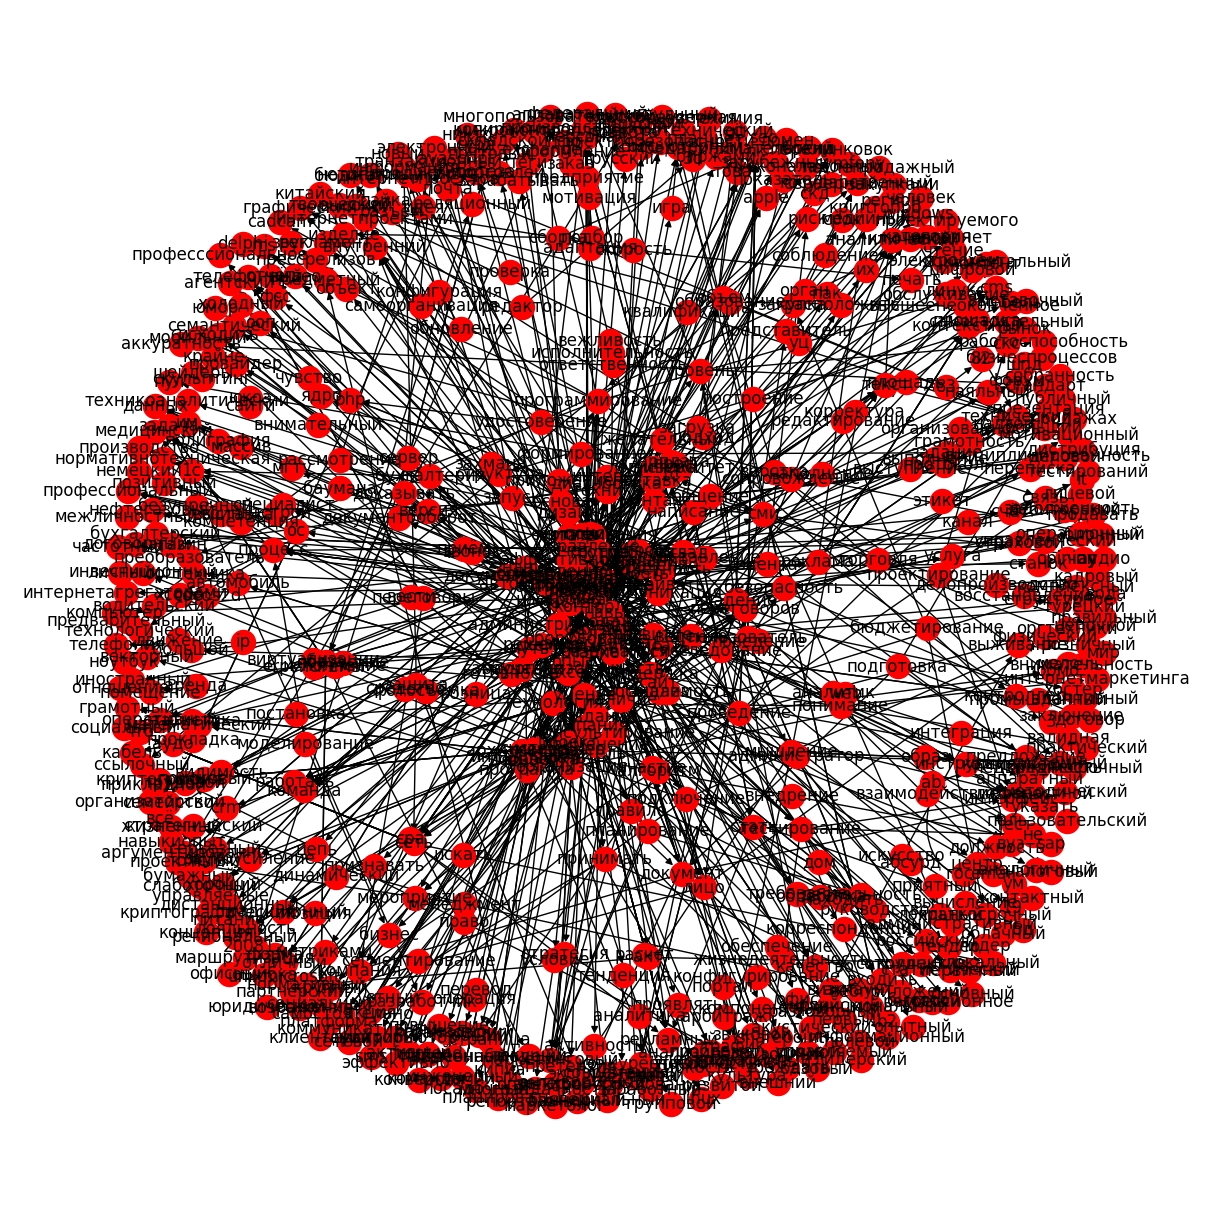

In [47]:
plt.figure(figsize=(12,12))

# pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues)

edge_labels = nx.get_edge_attributes(G, 'relation')
edge_labels = modifier_valve(edge_labels, dependencies_display)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.show()

In [48]:
components = list(nx.connected_components(G.to_undirected()))

# Находим компонент с наибольшим количеством узлов
largest_component = max(components, key=len)

# Создаем подграф из самого большого компонента
H = G.subgraph(largest_component).copy()

In [25]:
plt.figure(figsize=(12,12))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw(H, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)

# edge_labels = nx.get_edge_attributes(H, 'relation')
# nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red')
plt.show()

ImportError: requires pygraphviz http://pygraphviz.github.io/

<Figure size 1200x1200 with 0 Axes>

In [134]:
import math
def pos_on_circular_layout(l:list, r=1, center = (0, 0)):
    angle_step = math.pi*2/(len(l) -1)
    angle = 0
    pos = {}
    for node in l:
        pos[node] = np.array((math.sin(angle)*r + center[0], math.cos(angle)*r + center[1]))
        # pos[node] = (1, 0)
        angle += angle_step
    return pos

100%|██████████| 36/36 [00:00<?, ?it/s]


{'ключевой', 'проектируемого', 'юридический', 'тестирование', 'электронный', 'информация', '1с', 'кампания', 'документооборот', 'процесс', 'федеральный', 'активный', 'производство', 'професссиональное', 'комплексный', 'контекстный', 'электрический', 'приложение', 'кипиа', 'дебиторский', 'медицинский', 'физический', 'проектный', 'рекламный', 'звуковой', 'посадочный', 'учёт', 'первый', 'паяльный', 'клиентский', 'реляционный', 'локальный', 'текущий', 'сетевой', 'опыт', 'лояльный', 'социальный', 'склад', 'промышленный', 'нефтегазовый', 'больший', 'толстый', 'математический', 'многозадачность'}


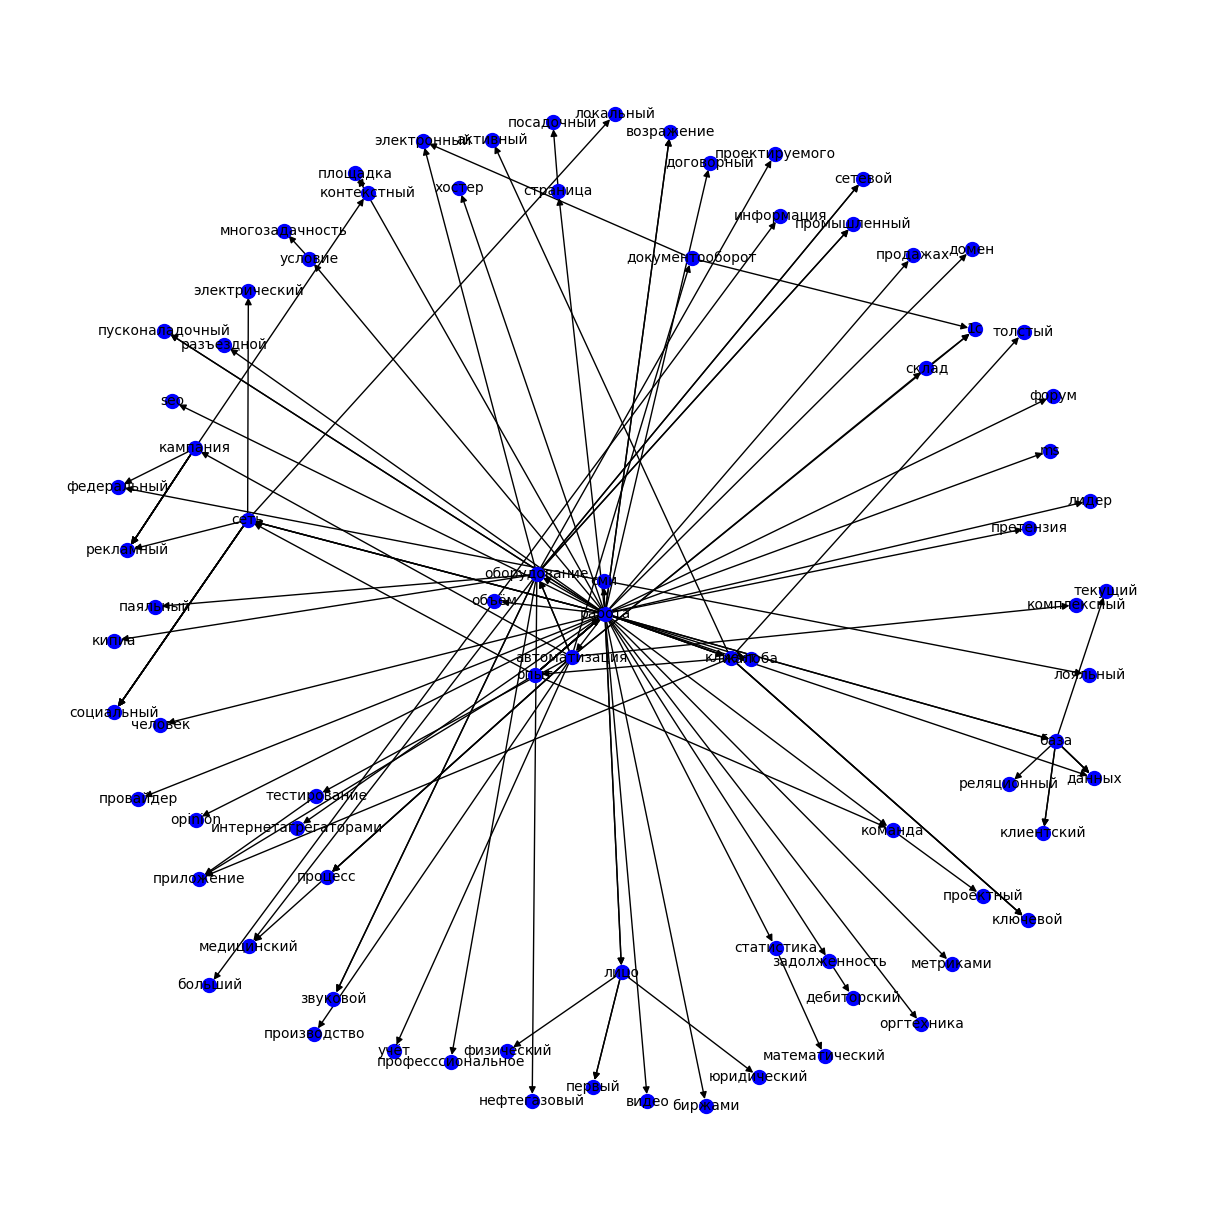

In [146]:
center_node = max(list(H.degree()), key=lambda x: x[1])
first_level_neighbors = [*H.neighbors(center_node[0])] 
# first_level_neighbors.append(center_node[0])

second_level_neighbors = set(first_level_neighbors)
for neighbor in tqdm(first_level_neighbors):
    second_level_neighbors.update(G.neighbors(neighbor))

second_level_neighbors = second_level_neighbors.difference(first_level_neighbors)
print(second_level_neighbors)
D = H.subgraph(set(first_level_neighbors + [*second_level_neighbors] + [center_node[0]])).copy()

pos = nx.layout.spring_layout(D, k=0.1)
# pos = {}
# pos.update(pos_on_circular_layout(first_level_neighbors, r=0.5))
# pos.update(pos_on_circular_layout(second_level_neighbors, r=1))
pos[center_node[0]] = (0, 0)

edge_labels = nx.get_edge_attributes(D, 'relation')
edge_labels = modifier_valve(edge_labels, dependencies_display)

plt.figure(figsize=(12,12))
# nx.draw_networkx_edge_labels(D, pos, edge_labels=edge_labels, font_color='red')
nx.draw(D, 
        with_labels=True, 
        node_color='b', 
        edge_cmap=plt.cm.Blues, 
        pos = pos,
        node_size=100,
        font_size=10
        )


In [209]:
len(H.nodes())

625

In [199]:
edges_with_attributes = G.edges(data=True)

# Выводим ребра и их атрибуты
for u, v, attributes in edges_with_attributes:
    print(f"Ребро ({u}, {v}) имеет атрибуты: {attributes}")

Ребро (текстов, технических) имеет атрибуты: {'relation': 'mod'}
Ребро (написание, текстов) имеет атрибуты: {'relation': 'nmod'}
Ребро (навыки, коммуникативные) имеет атрибуты: {'relation': 'mod'}
Ребро (навыки, продаж) имеет атрибуты: {'relation': 'nmod'}
Ребро (навыки, организаторские) имеет атрибуты: {'relation': 'mod'}
Ребро (навыки, презентации) имеет атрибуты: {'relation': 'nmod'}
Ребро (интерфейсов, пользовательских) имеет атрибуты: {'relation': 'mod'}
Ребро (проектирование, интерфейсов) имеет атрибуты: {'relation': 'nmod'}
Ребро (заданий, технических) имеет атрибуты: {'relation': 'mod'}
Ребро (разработка, заданий) имеет атрибуты: {'relation': 'nmod'}
Ребро (продажи, активные) имеет атрибуты: {'relation': 'mod'}
Ребро (продажи, холодные) имеет атрибуты: {'relation': 'mod'}
Ребро (ведение, переговоров) имеет атрибуты: {'relation': 'nmod'}
Ребро (ведение, отчетности) имеет атрибуты: {'relation': 'nmod'}
Ребро (проведение, презентаций) имеет атрибуты: {'relation': 'nmod'}
Ребро (по

In [ ]:
G = nx.MultiDiGraph()
G.

In [134]:
G = nx.MultiDiGraph()

# for i, row in tqdm(df_raw[:10].iterrows()):
#     # print(row["id"])
#     G.add_node(row["id"])
test_size = 10


G.add_nodes_from(df_raw[:test_size]["id"], subset="res")
G.add_nodes_from(df_raw[:test_size]["employer_name"].unique(), subset="employer_name")
G.add_edges_from(zip(df_raw[:test_size]["employer_name"], df_raw[:test_size]["id"]) )

G

In [133]:
G.edg

DegreeView({'Evelyn Jefferson': 8, 'Laura Mandeville': 7, 'Theresa Anderson': 8, 'Brenda Rogers': 7, 'Charlotte McDowd': 4, 'Frances Anderson': 4, 'Eleanor Nye': 4, 'Pearl Oglethorpe': 3, 'Ruth DeSand': 4, 'Verne Sanderson': 4, 'Myra Liddel': 4, 'Katherina Rogers': 6, 'Sylvia Avondale': 7, 'Nora Fayette': 8, 'Helen Lloyd': 5, 'Dorothy Murchison': 2, 'Olivia Carleton': 2, 'Flora Price': 2, 'E1': 3, 'E2': 3, 'E3': 6, 'E4': 4, 'E5': 8, 'E6': 8, 'E7': 10, 'E8': 14, 'E9': 12, 'E10': 5, 'E11': 4, 'E12': 6, 'E13': 3, 'E14': 3})

In [135]:
labels = dict(zip(df_raw[:test_size]["id"], df_raw[:test_size]["name"]))
labels.update(dict(zip(df_raw[:test_size]["employer_name"], df_raw[:test_size]["employer_name"])))
pprint(labels)

{16260123: 'Системный аналитик',
 16260126: 'Менеджер по работе с клиентами',
 16260127: 'Ведущий менеджер по персоналу',
 16260130: 'Специалист по подбору персонала',
 16260135: 'Специалист по подбору персонала',
 16260140: 'Аналитик баз данных',
 16260146: 'Специалист по подбору персонала',
 16260148: '.NET Developer (to Czech Republic)',
 16260163: 'Секретарь-администратор',
 16260166: 'Специалист по работе с клиентами',
 'Embria': 'Embria',
 'Glass Technology': 'Glass Technology',
 'VIADATA': 'VIADATA',
 'Брайт Солюшенз': 'Брайт Солюшенз',
 'Галкина А.А.': 'Галкина А.А.',
 'Устинова А.Г.': 'Устинова А.Г.'}


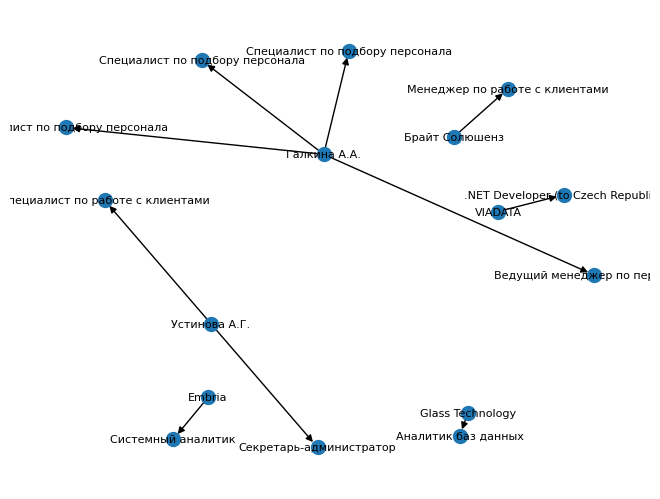

In [136]:

nx.draw(G, 
        with_labels=True, 
        node_size=100, 
        labels=labels,
        pos=nx.layout.spring_layout(G),
        font_size=8)

In [131]:
communities[0]

frozenset({'Brenda Rogers',
           'Charlotte McDowd',
           'E1',
           'E2',
           'E3',
           'E4',
           'E5',
           'E6',
           'E7',
           'Eleanor Nye',
           'Evelyn Jefferson',
           'Frances Anderson',
           'Laura Mandeville',
           'Pearl Oglethorpe',
           'Ruth DeSand',
           'Theresa Anderson'})

In [128]:
len(communities)

3

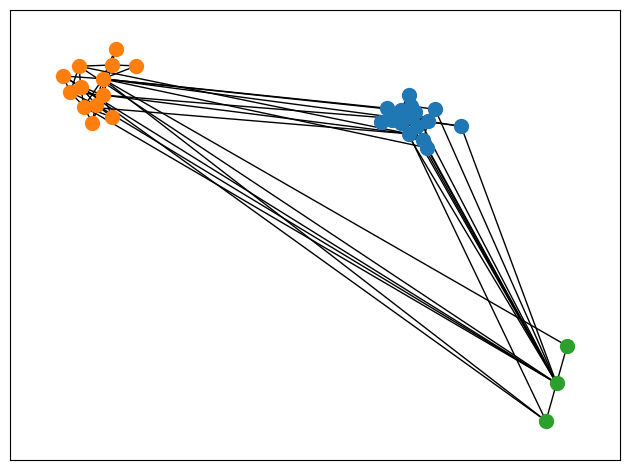

In [122]:
G = nx.davis_southern_women_graph()  # Example graph
communities = nx.community.greedy_modularity_communities(G)

supergraph = nx.cycle_graph(len(node_types))
superpos = nx.spring_layout(G, scale=50)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))

# Nodes colored by cluster
for nodes, clr in zip(communities, ("tab:blue", "tab:orange", "tab:green")):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
nx.draw_networkx_edges(G, pos=pos)

plt.tight_layout()
plt.show()